In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import itertools
class LeastSquaresClassifier(object):
    def __init__(self, class_weighted = False):
        self.class_weighted = class_weighted
        
    def _dist(self, x1, x2):
        return np.sum((x1 - x2) ** 2)
    
    def _add_bias_unit(self, X, how = 'column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    def fit(self, X, y, test_X = None):
        self.X = X
        self.y = y
        X_ = self._add_bias_unit(self.X)
        if not self.class_weighted:
            self.weight = np.linalg.pinv(X_.transpose().dot(X_)).dot(X_.transpose().dot(y))
            return self
        else:
            #ラベルごとにデータを整列
            sorted_idx =np.argsort(y)
            self.X = self.X[sorted_idx]
            self.y = self.y[sorted_idx]
            neg_samples, pos_samples = len(np.where(self.y == -1)[0]), len(np.where(self.y == 1)[0])
            pos_X = self.X[-pos_samples:]
            neg_X = self.X[neg_samples:]
            #エネルギー距離を計算
            test_samples = test_X.shape[0]
            dist_pos_pos, dist_neg_neg, dist_neg_pos, dist_pos_test, dist_neg_test = 0, 0, 0, 0, 0
            for x1, x2 in itertools.product(pos_X, pos_X):
                dist_pos_pos += self._dist(x1, x2)
            for x1, x2 in itertools.product(neg_X, neg_X):
                dist_neg_neg += self._dist(x1, x2)
            for x1, x2 in itertools.product(neg_X, pos_X):
                dist_neg_pos += self._dist(x1, x2)
            for x1, x2 in itertools.product(neg_X, test_X):
                dist_neg_test += self._dist(x1, x2)
            for x1, x2 in itertools.product(pos_X, test_X):
                dist_pos_test += self._dist(x1, x2)
            dist_pos_pos /= (pos_samples**2)
            dist_neg_neg /= (neg_samples**2)
            dist_neg_pos /= (pos_samples * neg_samples)
            dist_pos_test /= (pos_samples * test_samples)
            dist_neg_test /= (neg_samples * test_samples)
            class_balance = (dist_neg_pos - dist_neg_neg - dist_pos_test + dist_neg_test) / (2*dist_neg_pos - dist_pos_pos - dist_neg_neg)
            class_balance = min(1, max(0, class_balance))
            self.class_weight = np.diag([class_balance] * neg_samples + [1 - class_balance] * pos_samples)
            self.weight = np.linalg.pinv(X_.transpose().dot(self.class_weight).dot(X_)).dot(X_.transpose().dot(self.class_weight).dot(y))
            return self

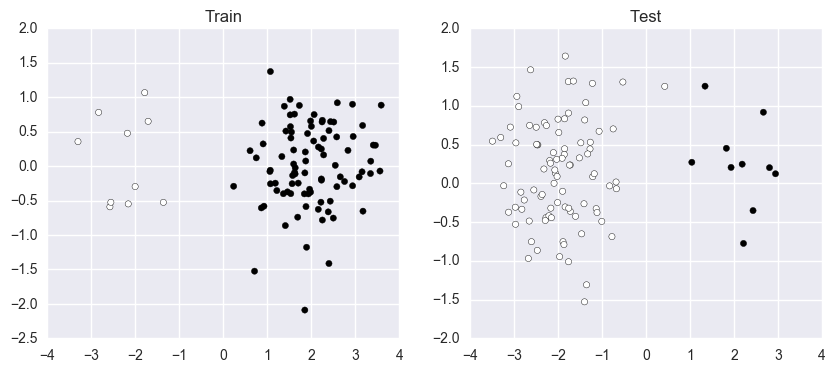

In [35]:
n = 200
u = np.array([2] * (n/2) + [-2] * (n/2)) + np.random.randn(n)/1.5
v = np.random.randn(n)/1.5
X = np.dstack([u,v])[0]
y = np.array([1] * (n/2) + [-1] * (n/2))
train_X, train_y = X[10:-90], y[10:-90]
test_X, test_y = np.concatenate([X[:10], X[-90:]]), np.concatenate([y[:10], y[-90:]])

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
ax1.scatter(train_X[:,0], train_X[:,1], c = train_y)
ax2.scatter(test_X[:,0], test_X[:,1], c = test_y)
ax1.set_title("Train")
ax2.set_title("Test")

In [36]:
clf1 = LeastSquaresClassifier(class_weighted=False).fit(train_X, train_y)
clf2 = LeastSquaresClassifier(class_weighted=True).fit(train_X, train_y, test_X)
print(clf1.weight)
print(clf2.weight)

[ 0.24030942  0.35793339 -0.04648241]
[ 0.22247659  0.36633183 -0.05027713]


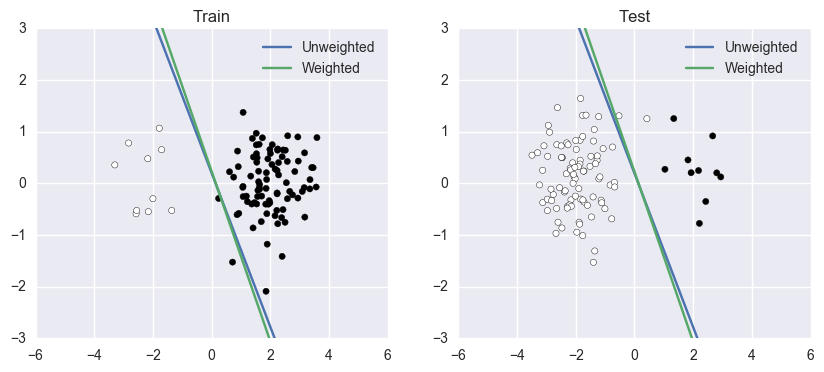

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 4))
ax1.scatter(train_X[:,0], train_X[:,1], c = train_y)
ax2.scatter(test_X[:,0], test_X[:,1], c = test_y)
ax1.set_title("Train")
ax2.set_title("Test")

def draw_boundary(x, clf):
    return - (clf.weight[1] * x + clf.weight[2]) /clf.weight[0] 

boundary_normal = pd.Series(draw_boundary(np.arange(-6, 6, 0.5), clf1), index = np.arange(-6, 6, 0.5))
boundary_weight = pd.Series(draw_boundary(np.arange(-6, 6, 0.5), clf2), index = np.arange(-6, 6, 0.5))
boundary_normal.plot(ax = ax1, label = "Unweighted")
boundary_weight.plot(ax = ax1, label = "Weighted")
boundary_normal.plot(ax = ax2, label = "Unweighted")
boundary_weight.plot(ax = ax2, label = "Weighted")
ax1.set_xlim([-6, 6])
ax1.set_ylim([-3, 3])
ax2.set_xlim([-6, 6])
ax2.set_ylim([-3, 3])
ax1.legend()
ax2.legend()

In [39]:
clf2.class_weight

array([[ 0.01040922,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01040922,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01040922, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.98959078,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.98959078,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.98959078]])